In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from dory.classifier import KNNClassifier
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("kc2.csv", header=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,2.140000e+02,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,59.247664,7.752336,3.845794,5.616822,157.172897,978.048084,0.202897,13.502056,38.770607,3.800393e+04,...,45.266355,3.490654,6.897196,0.485981,11.322430,21.691589,96.242991,62.261682,14.387850,0.500000
std,112.877762,16.222611,10.085063,12.009890,341.934668,2725.522314,0.223949,13.979825,41.260827,1.741898e+05,...,94.060160,7.646375,12.708678,1.506571,7.138059,30.178627,209.900170,132.259301,32.442134,0.501172
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,6.000000,1.000000,1.000000,1.000000,12.250000,36.500000,0.050000,3.000000,9.292500,1.000000e+02,...,4.000000,0.000000,0.000000,0.000000,5.000000,3.000000,8.000000,4.000000,1.000000,0.000000
50%,29.000000,3.000000,1.000000,2.500000,69.500000,325.655000,0.090000,10.000000,31.260000,3.258485e+03,...,22.000000,0.000000,3.000000,0.000000,11.000000,15.000000,39.500000,27.500000,5.000000,0.500000
75%,71.500000,8.000000,4.000000,6.000000,184.000000,1008.702500,0.300000,20.205000,55.107500,1.961718e+04,...,53.750000,3.000000,9.000000,0.000000,16.000000,29.750000,113.000000,72.500000,15.000000,1.000000
max,1275.000000,180.000000,125.000000,143.000000,3982.000000,33814.560000,1.000000,103.530000,415.060000,2.147484e+06,...,1107.000000,44.000000,121.000000,11.000000,47.000000,325.000000,2469.000000,1513.000000,361.000000,1.000000


In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42069
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(171, 21) (43, 21) (171,) (43,)


In [4]:
random_state = 42069

clazz_mapper = {
    0.0: "normal",
    1.0: "defect",
}

classifiers = [
    ("1NN (Euclidean)", KNNClassifier(n_neighbors=1, metric="euclidean")),
    ("5NN (Euclidean)", KNNClassifier(n_neighbors=5, metric="euclidean")),
    ("1NN (Mahalanobis)", KNNClassifier(n_neighbors=1, metric="mahalanobis")),
    ("5NN (Mahalanobis)", KNNClassifier(n_neighbors=5, metric="mahalanobis")),
    ("Decision Tree with Gini", DecisionTreeClassifier(random_state=random_state, criterion="gini")),
]

results = {
    name: {
        "global_accuracy": [],
        "y_true_all": [],
        "y_pred_all": [],
        "precision_per_fold": [],
        "recall_per_fold": [],
        "f1_per_fold": [],
    }
    for name, _ in classifiers
}

n_folds = 10
logger = logging.getLogger("KFoldCV")

cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

for i, (train_index, test_index) in enumerate(cv.split(X)):
    logger.debug(f"Fold {i}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for name, clf in classifiers:
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)

        # Store predictions for later metric calculation
        results[name]["y_true_all"].extend(y_test)
        results[name]["y_pred_all"].extend(y_pred)

        # Calculate metrics per fold
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name]["precision_per_fold"].append(precision)
        results[name]["recall_per_fold"].append(recall)
        results[name]["f1_per_fold"].append(f1)
        results[name]["global_accuracy"].append(accuracy)

        logger.debug(
            f"classifier {name}, Accuracy: {accuracy:.4f}, Fold {i + 1}/{n_folds}"
        )

In [5]:
# Calculate global metrics for each classifier
metrics_data = []

for name, clf in classifiers:
    mean_accuracy = np.mean(results[name]["global_accuracy"])
    std_accuracy = np.std(results[name]["global_accuracy"])
    
    mean_precision = np.mean(results[name]["precision_per_fold"])
    std_precision = np.std(results[name]["precision_per_fold"])
    
    mean_recall = np.mean(results[name]["recall_per_fold"])
    std_recall = np.std(results[name]["recall_per_fold"])
    
    mean_f1 = np.mean(results[name]["f1_per_fold"])
    std_f1 = np.std(results[name]["f1_per_fold"])
    
    # Store metrics for table
    metrics_data.append({
        "Classifier": name,
        "Accuracy (Mean)": f"{mean_accuracy:.4f}",
        "Accuracy (Std)": f"{std_accuracy:.4f}",
        "Precision (Mean)": f"{mean_precision:.4f}",
        "Precision (Std)": f"{std_precision:.4f}",
        "Recall (Mean)": f"{mean_recall:.4f}",
        "Recall (Std)": f"{std_recall:.4f}",
        "F1-Score (Mean)": f"{mean_f1:.4f}",
        "F1-Score (Std)": f"{std_f1:.4f}",
    })

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Classifier,Accuracy (Mean),Accuracy (Std),Precision (Mean),Precision (Std),Recall (Mean),Recall (Std),F1-Score (Mean),F1-Score (Std)
0,1NN (Euclidean),0.7152,0.1018,0.7274,0.1038,0.7152,0.1018,0.7156,0.1040
1,5NN (Euclidean),0.7665,0.0612,0.7861,0.0670,0.7665,0.0612,0.7668,0.0616
2,1NN (Mahalanobis),0.6968,0.0961,0.7354,0.0940,0.6968,0.0961,0.6930,0.1022
3,5NN (Mahalanobis),0.7751,0.0705,0.8102,0.0626,0.7751,0.0705,0.7725,0.0756
4,Decision Tree with Gini,0.6972,0.0952,0.7159,0.0936,0.6972,0.0952,0.6960,0.0972


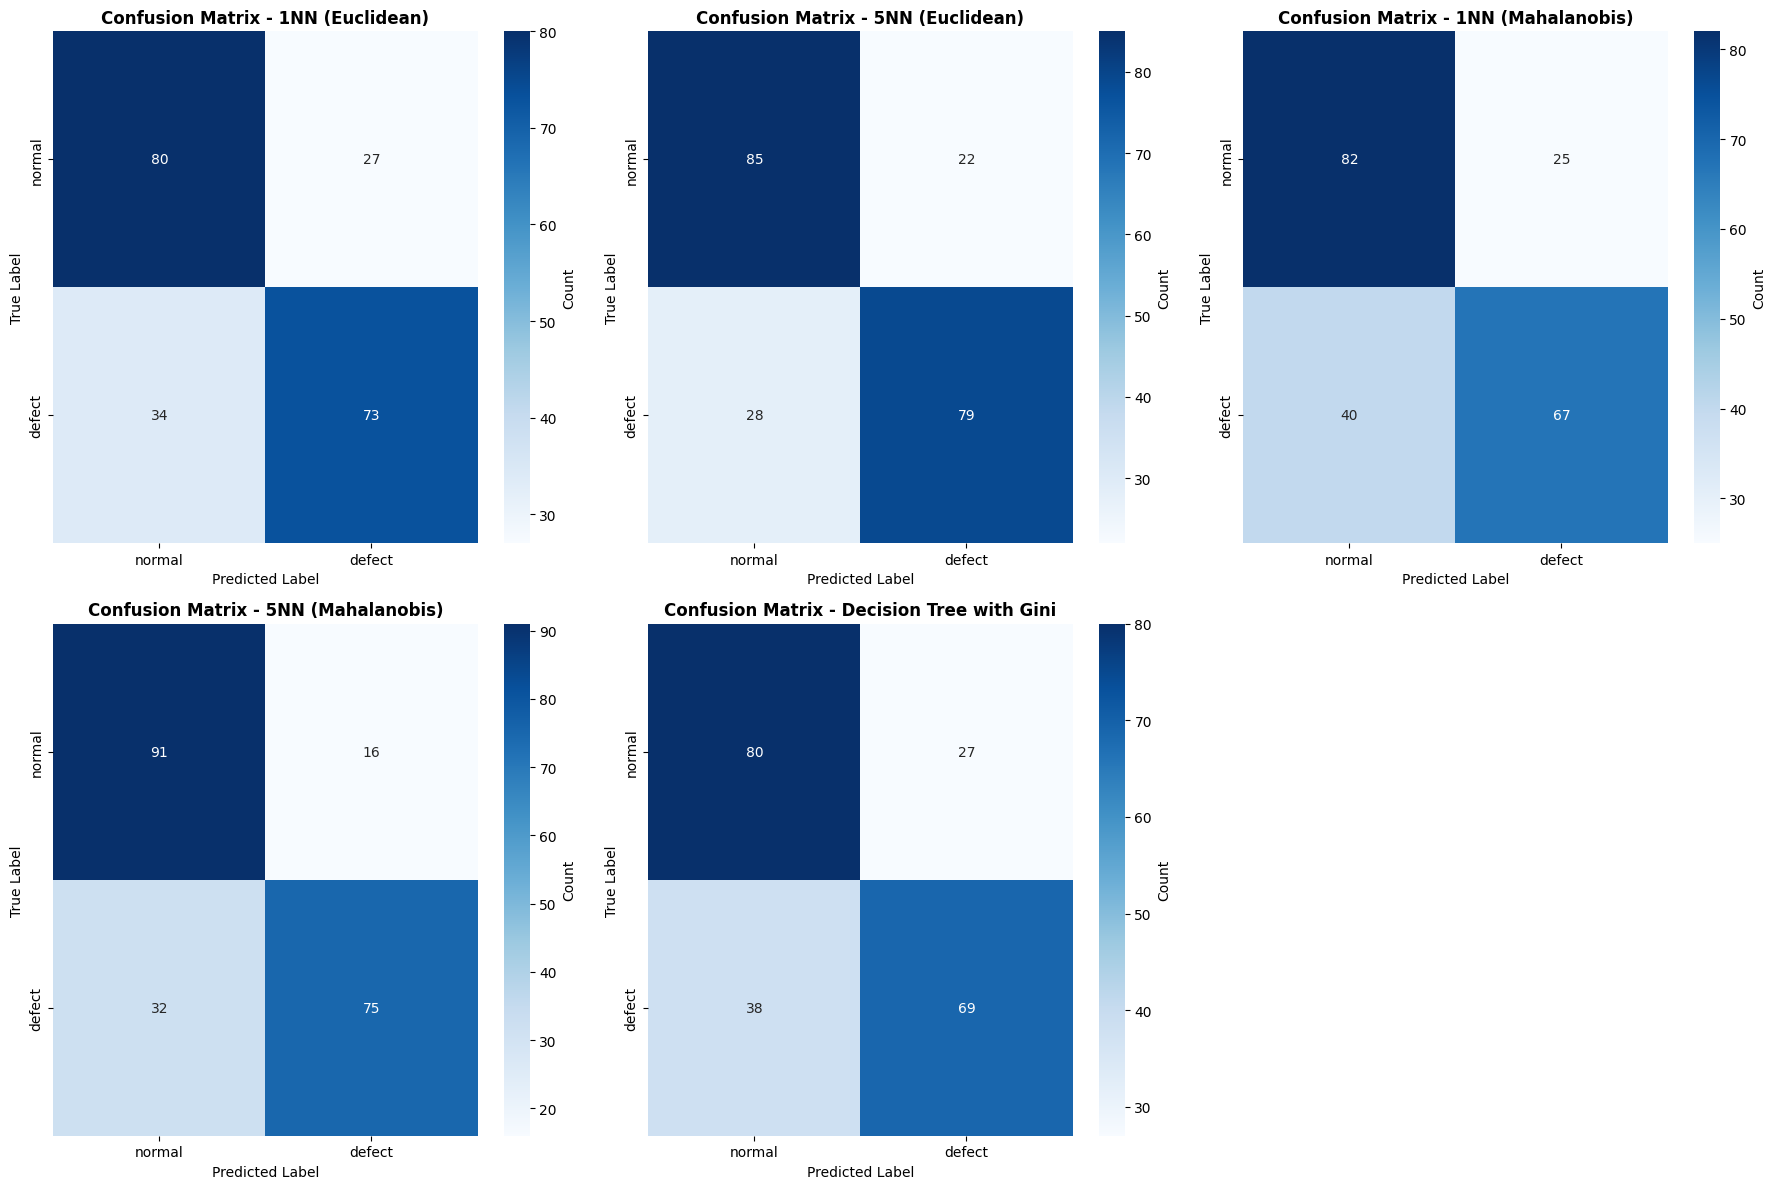

In [6]:
n_classifiers = len(classifiers)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

unique_classes = sorted(np.unique(y))
class_labels = [clazz_mapper[cls] for cls in unique_classes]

for idx, (name, clf) in enumerate(classifiers):
    y_true = np.array(results[name]["y_true_all"])
    y_pred = np.array(results[name]["y_pred_all"])
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'},
                xticklabels=class_labels,
                yticklabels=class_labels)
    axes[idx].set_title(f'Confusion Matrix - {name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)

if n_classifiers < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()